## Anchor Direction Visualization Framework: DeepSurv trained on the SUPPORT dataset (where the encoder does *not* have a Euclidean norm 1 constraint)

This notebook is nearly identical to the version with the Euclidean norm 1 constraint.

### Loading in data (including some outputs from the already trained neural survival analysis model)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = ['sans-serif', 'Arial']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import numpy as np
import pandas as pd
import scipy.stats

from visualization_utils import get_experiment_data, l2_normalize_rows, longest_common_prefix, \
    compute_median_survival_times

Some explanation of the variables below:

- `emb_direction`: these are embedding vectors for anchor direction estimation data
- `emb_vis`: these are embedding vectors for the visualization raw inputs
- `raw_direction`: raw inputs of the anchor direction estimation data
- `raw_vis`: visualization raw inputs
- `label_direction`: survival labels (2 columns: column 0 stores observed times and column 1 stores event indicators) of the anchor direction estimation data
- `label_vis`: survival labels of the visualization raw inputs
- `unique_train_times`: discretized time grid used for the predicted survival curves
- `predicted_surv_vis`: predicted survival curves of the visualization raw inputs (so each visualization raw input has a predicted survival curve that is specified for the time grid given by `unique_train_times`

In [2]:
emb_direction, emb_vis, raw_direction, raw_vis, label_direction, label_vis, \
    _, unique_train_times, predicted_surv_vis \
        = get_experiment_data('support', '../train_models/output_tabular_no_hypersphere')

In [3]:
emb_direction.shape

(665, 6)

### 2D PCA plot of the visualization data

Unlike in the case where the encoder's outputs were on the unit hypersphere, now the encoder's outputs are unconstrained. From the 2D PCA plot, it looks like the variation in the anchor direction estimation data's embedding vectors is nearly all explained by the first principal component direction (which captures 99.3% of the variance!). In particular, the embedding vectors in this case have information stored mostly in magnitudes and not so much in angles, so we should expect to see the "bunching up at -1 and 1" phenomenon mentioned in the paper when we look at projection values.

In [4]:
median_surv_time_estimates = compute_median_survival_times(predicted_surv_vis, unique_train_times)

Text(0.5, 1.0, '2D PCA plot of a DeepSurv embedding space (SUPPORT dataset)')

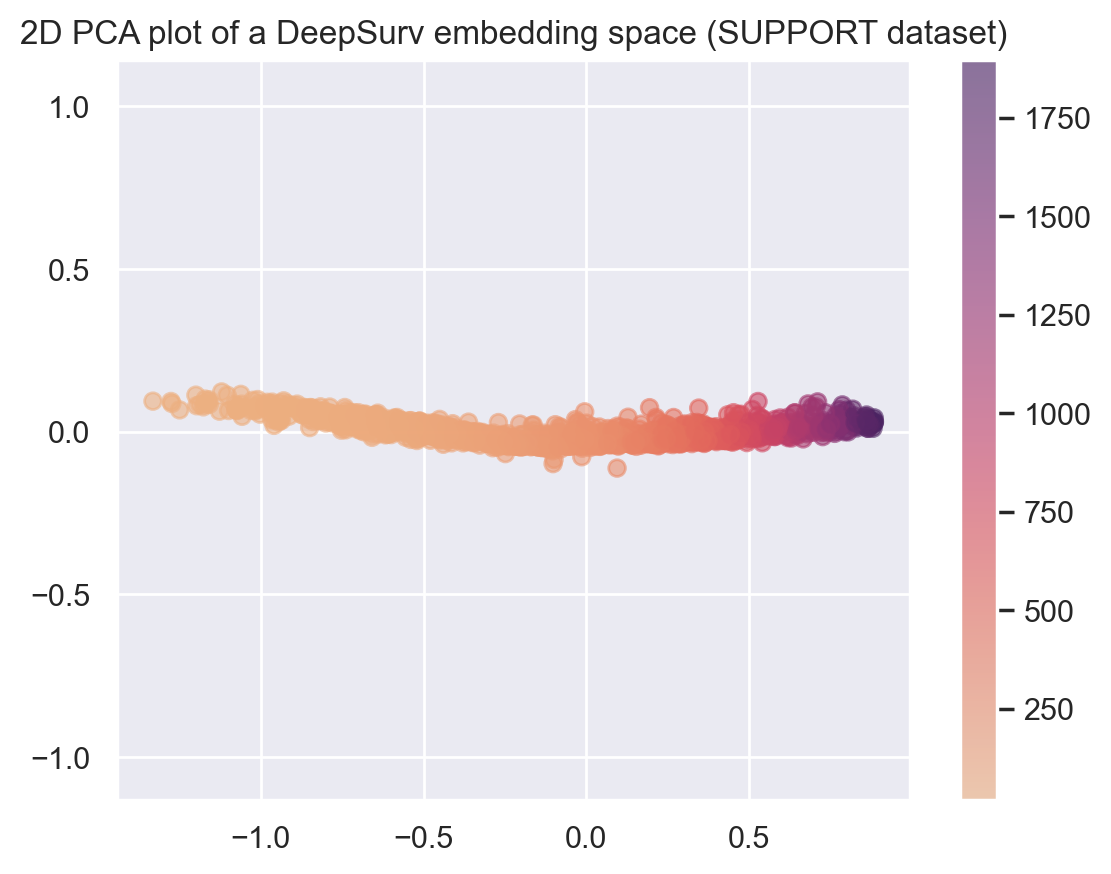

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_vis_pca_2d = pca.fit_transform(emb_vis)
plt.axis('equal')
plt.scatter(emb_vis_pca_2d[:, 0], emb_vis_pca_2d[:, 1], alpha=.6, c=median_surv_time_estimates, cmap='flare')
plt.colorbar()
plt.title('2D PCA plot of a DeepSurv embedding space (SUPPORT dataset)')

In [6]:
pca.explained_variance_ratio_

array([0.99266496, 0.00377672])

### 2D t-SNE plot of the visualization data

/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, '2D t-SNE plot of a DeepSurv embedding space (SUPPORT dataset)')

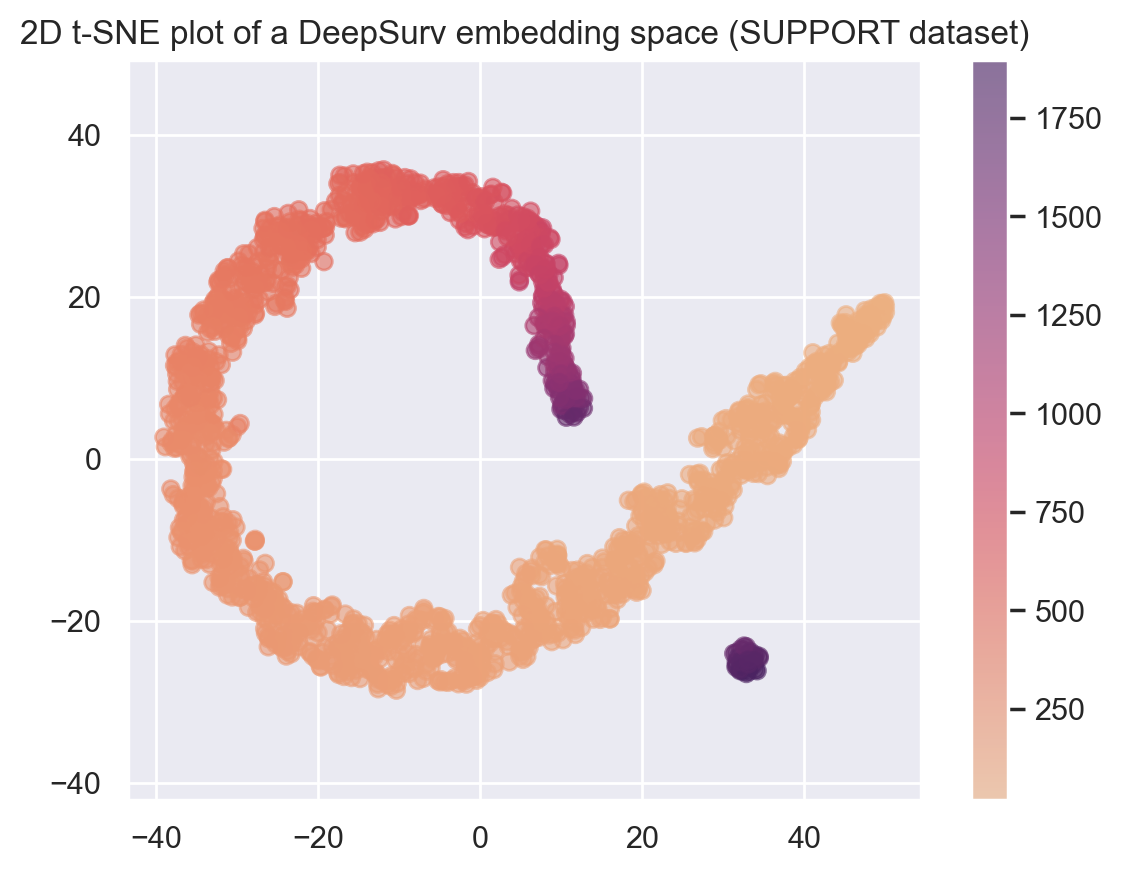

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50, random_state=3676767249)
emb_vis_tsne_2d = tsne.fit_transform(emb_vis)
plt.axis('equal')
plt.scatter(emb_vis_tsne_2d[:, 0], emb_vis_tsne_2d[:, 1], alpha=.6, c=median_surv_time_estimates, cmap='flare')
plt.colorbar()
plt.title('2D t-SNE plot of a DeepSurv embedding space (SUPPORT dataset)')

### For different choices for the number of components, fit a Gaussian mixture model

In [8]:
from sklearn.mixture import GaussianMixture
from lifelines.statistics import pairwise_logrank_test

seed = 1861600023

n_init = 100
n_clusters_to_try = list(range(2, 11))
logrank_p_values = []
cluster_assignments = []

for n_clusters in n_clusters_to_try:
    print('Trying %d clusters...' % n_clusters)
    
    model = GaussianMixture(n_clusters, random_state=seed, n_init=n_init)
    cluster_assignment = model.fit_predict(emb_direction)

    result = pairwise_logrank_test(label_direction[:, 0],
                                   cluster_assignment,
                                   label_direction[:, 1])
    logrank_p_values.append(result.p_value)
    cluster_assignments.append(cluster_assignment)

Trying 2 clusters...
Trying 3 clusters...
Trying 4 clusters...
Trying 5 clusters...
Trying 6 clusters...
Trying 7 clusters...
Trying 8 clusters...
Trying 9 clusters...
Trying 10 clusters...


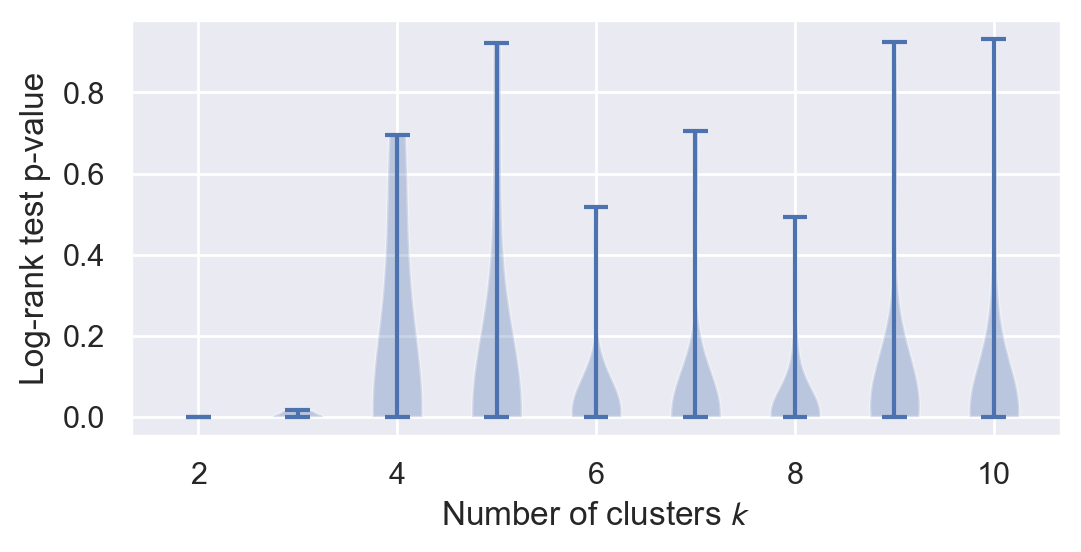

In [9]:
plt.figure(figsize=(6, 2.7))
plt.violinplot(logrank_p_values, n_clusters_to_try)
plt.xlabel('Number of clusters $k$')
plt.ylabel('Log-rank test p-value')
plt.savefig('support-logrank-pvalue-vs-nclusters-no-hypersphere.pdf', bbox_inches='tight')

### Using different clusters' anchor directions, make various visualizations

In [10]:
final_n_clusters = 3

In [11]:
final_cluster_assignment = cluster_assignments[n_clusters_to_try.index(final_n_clusters)]

/home/george/anaconda3_UDA/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Raw count')

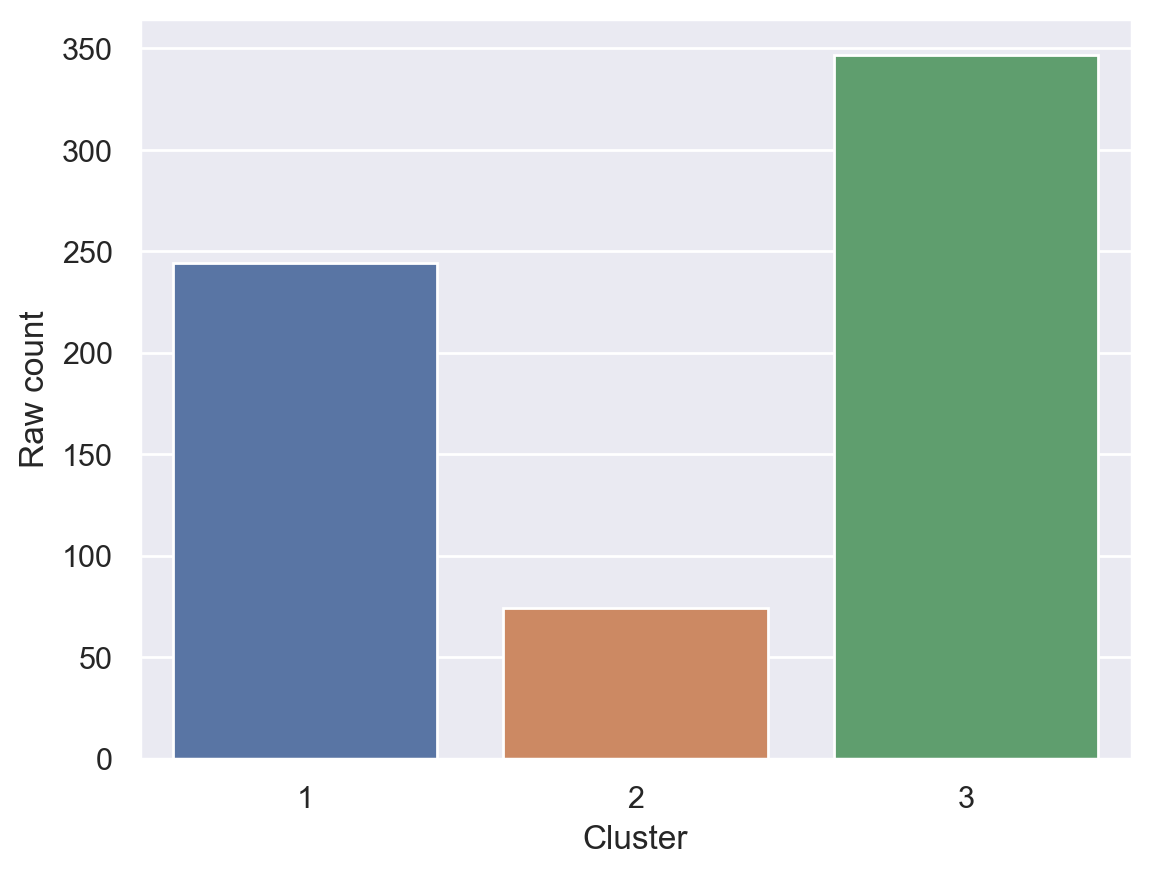

In [12]:
from collections import Counter
histogram = Counter(final_cluster_assignment)
sns.barplot(np.arange(final_n_clusters) + 1,
            [histogram[cluster_idx] for cluster_idx in range(final_n_clusters)])
plt.xlabel('Cluster')
plt.ylabel('Raw count')

In [13]:
center_of_mass = emb_direction.mean(axis=0)

In [14]:
anchor_directions = np.array([emb_direction[final_cluster_assignment == cluster_idx].mean(axis=0) - center_of_mass
                              for cluster_idx in range(final_n_clusters)])

In [15]:
# code that discretizes the all raw features (discrete and continuous) for raw feature probability heatmap
# visualizations (this code is specific to the SUPPORT dataset but can be modified for other tabular data)

from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder

def transform(raw_features, continuous_n_bins=5):
    feature_names = ['age', 'female', 'race', 'number of comorbidities',
                     'diabetes', 'dementia', 'cancer', 'mean arterial blood pressure',
                     'heart rate', 'respiration rate', 'temperature', 'white blood count',
                     'serum sodium', 'serum creatinine']
    binary_indices = [1, 4, 5]
    continuous_indices = [0, 3, 7, 8, 9, 10, 11, 12, 13]
    discretized_features = []
    discretized_feature_names = []
    all_n_bins_to_use = []
    for idx in continuous_indices:
        n_bins_to_use = continuous_n_bins
        discretizer = KBinsDiscretizer(n_bins=n_bins_to_use,
                                       strategy='quantile',
                                       encode='onehot-dense')
        new_features = discretizer.fit_transform(raw_features[:, idx].reshape(-1, 1).astype(float))
        if discretizer.n_bins_[0] != n_bins_to_use:
            n_bins_to_use = discretizer.n_bins_[0]

        if n_bins_to_use > 1:
            discretized_features.append(new_features)
            for bin_idx in range(n_bins_to_use):
                if bin_idx == 0:
                    discretized_feature_names.append(feature_names[idx] + ' bin#1(-inf,%.2f)' % discretizer.bin_edges_[0][bin_idx+1])
                elif bin_idx == n_bins_to_use - 1:
                    discretized_feature_names.append(feature_names[idx] + ' bin#%d[%.2f,inf)' % (n_bins_to_use, discretizer.bin_edges_[0][bin_idx]))
                else:
                    # print(discretizer.bin_edges_[0][bin_idx:bin_idx+2])
                    discretized_feature_names.append(feature_names[idx] + ' bin#%d[%.2f,%.2f)' % tuple([bin_idx + 1] + list(discretizer.bin_edges_[0][bin_idx:bin_idx+2])))
        all_n_bins_to_use.append(n_bins_to_use)
    for idx in binary_indices:
        discretized_features.append(raw_features[:, idx].reshape(-1, 1).astype(float))
        discretized_feature_names.append(feature_names[idx])
        all_n_bins_to_use.append(1)

    # race
    discretizer = OneHotEncoder(sparse=False, categories=[[0, 1, 2, 3, 4, 5]])
    discretized_features.append(discretizer.fit_transform(raw_features[:, 2].reshape(-1, 1).astype(float)))
    discretized_feature_names.extend(['race cat#1(unspecified)',
                                      'race cat#2(asian)',
                                      'race cat#3(black)',
                                      'race cat#4(hispanic)',
                                      'race cat#5(other)',
                                      'race cat#6(white)'])
    all_n_bins_to_use.append(6)

    # cancer
    discretizer = OneHotEncoder(sparse=False, categories=[[0, 1, 2]])
    discretized_features.append(discretizer.fit_transform(raw_features[:, 6].reshape(-1, 1).astype(float)))
    discretized_feature_names.extend(['cancer cat#1(no)',
                                      'cancer cat#2(yes)',
                                      'cancer cat#3(metastatic)'])
    all_n_bins_to_use.append(3)
    return np.hstack(discretized_features), discretized_feature_names, all_n_bins_to_use

In [16]:
raw_vis_discretized, discretized_feature_names, all_n_bins_to_use = transform(raw_vis)

/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


For each cluster, rank raw features using p-values from the chi-squared test of independence (raw feature vs projection value along the current cluster's anchor direction):

In [17]:
all_raw_feature_probability_heatmaps = []
all_bin_edges = []

n_bins = 7
emb_vis_normalized = l2_normalize_rows(emb_vis - center_of_mass[np.newaxis, :])
anchor_directions_normalized = l2_normalize_rows(anchor_directions)
for cluster_idx in range(final_n_clusters):
    projections = np.dot(emb_vis_normalized, anchor_directions_normalized[cluster_idx])

    bin_counts, bin_edges = np.histogram(projections, bins=n_bins)
    bin_edges_copy_with_inf_right_edge = bin_edges.copy()
    bin_edges_copy_with_inf_right_edge[-1] = np.inf

    bin_assignments = np.digitize(projections, bin_edges_copy_with_inf_right_edge) - 1

    heatmap = np.zeros((len(discretized_feature_names), n_bins))
    for discretized_feature_idx in range(len(discretized_feature_names)):
        for projection_bin_idx in range(n_bins):
            heatmap[discretized_feature_idx, projection_bin_idx] = raw_vis_discretized[bin_assignments == projection_bin_idx][:, discretized_feature_idx].mean()

    all_raw_feature_probability_heatmaps.append(heatmap)
    all_bin_edges.append(bin_edges)

    # compute ranking table
    projection_bin_counts = np.array([(bin_assignments == bin_idx).sum() for bin_idx in range(n_bins)])
    print('[Cluster %d]' % (cluster_idx + 1))
    current_row = 0
    variable_pval_pairs = []
    for variable_idx in range(len(all_n_bins_to_use)):
        n_bins_to_use = all_n_bins_to_use[variable_idx]
        if n_bins_to_use >= 2:
            prefix = \
                longest_common_prefix([discretized_feature_names[idx]
                                       for idx in range(current_row,
                                                        current_row + n_bins_to_use)])
            if prefix.endswith('(') or prefix.endswith('['):
                prefix = prefix[:-1]
            if prefix.endswith(' cat#') or prefix.endswith(' bin#'):
                prefix = prefix[:-5]
            prefix = prefix.strip()
            res = scipy.stats.chi2_contingency(
                heatmap[current_row:(current_row + n_bins_to_use), :]
                * projection_bin_counts[np.newaxis, :])
            variable_pval_pairs.append((prefix, res[1]))
        else:
            indicator_row = heatmap[current_row:(current_row + n_bins_to_use), :]
            res = scipy.stats.chi2_contingency(
                np.array([[indicator_row, 1. - indicator_row]])
                * projection_bin_counts[np.newaxis, :])
            # print(discretized_feature_names[current_row], res[1])
            variable_pval_pairs.append((discretized_feature_names[current_row], res[1]))
        current_row += n_bins_to_use
    for idx, (variable_name, pval) in enumerate(sorted(variable_pval_pairs, key=lambda x: x[1])):
        print(idx + 1, '-', variable_name, '-', pval)
        # print('%d &' % (idx + 1), variable_name, (('& $%.2E' % pval).replace('E-', '\\times 10^{-') + '}$ \\\\').replace('^{-0', '^{-'))
    print()

[Cluster 1]
1 - cancer - 4.349012801859094e-176
2 - age - 2.9037567764943408e-34
3 - dementia - 9.147181303080726e-15
4 - number of comorbidities - 4.7607068339390734e-14
5 - heart rate - 6.933865137092546e-09
6 - mean arterial blood pressure - 2.4844610715118064e-08
7 - diabetes - 3.434332911690643e-05
8 - female - 4.767126553510904e-05
9 - white blood count - 0.0005630557823801131
10 - temperature - 0.005937891002981198
11 - respiration rate - 0.1311027465095731
12 - serum creatinine - 0.31290708526457406
13 - serum sodium - 0.3319226071509428
14 - race - 0.5281060906010874

[Cluster 2]
1 - cancer - 3.405816171914894e-175
2 - age - 8.462478463500962e-36
3 - dementia - 6.135648375325167e-15
4 - number of comorbidities - 1.3834737255646125e-12
5 - heart rate - 7.644873428614123e-10
6 - mean arterial blood pressure - 1.9753729169357914e-08
7 - diabetes - 6.489444590668452e-05
8 - female - 0.0009969277329279706
9 - temperature - 0.008656177721196524
10 - white blood count - 0.01707476045

These are the projection bin edges, just for reference:

In [18]:
for cluster_idx in range(final_n_clusters):
    print(cluster_idx + 1, all_bin_edges[cluster_idx])

1 [-0.9999776  -0.71426686 -0.42855611 -0.14284537  0.14286537  0.42857611
  0.71428685  0.99999759]
2 [-0.99727761 -0.71239337 -0.42750913 -0.14262489  0.14225935  0.4271436
  0.71202784  0.99691208]
3 [-0.99999953 -0.71428648 -0.42857343 -0.14286037  0.14285268  0.42856573
  0.71427878  0.99999184]


Plot raw feature probability heatmaps (all in one big plot):

/tmp/ipykernel_4002473/3030289070.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.)


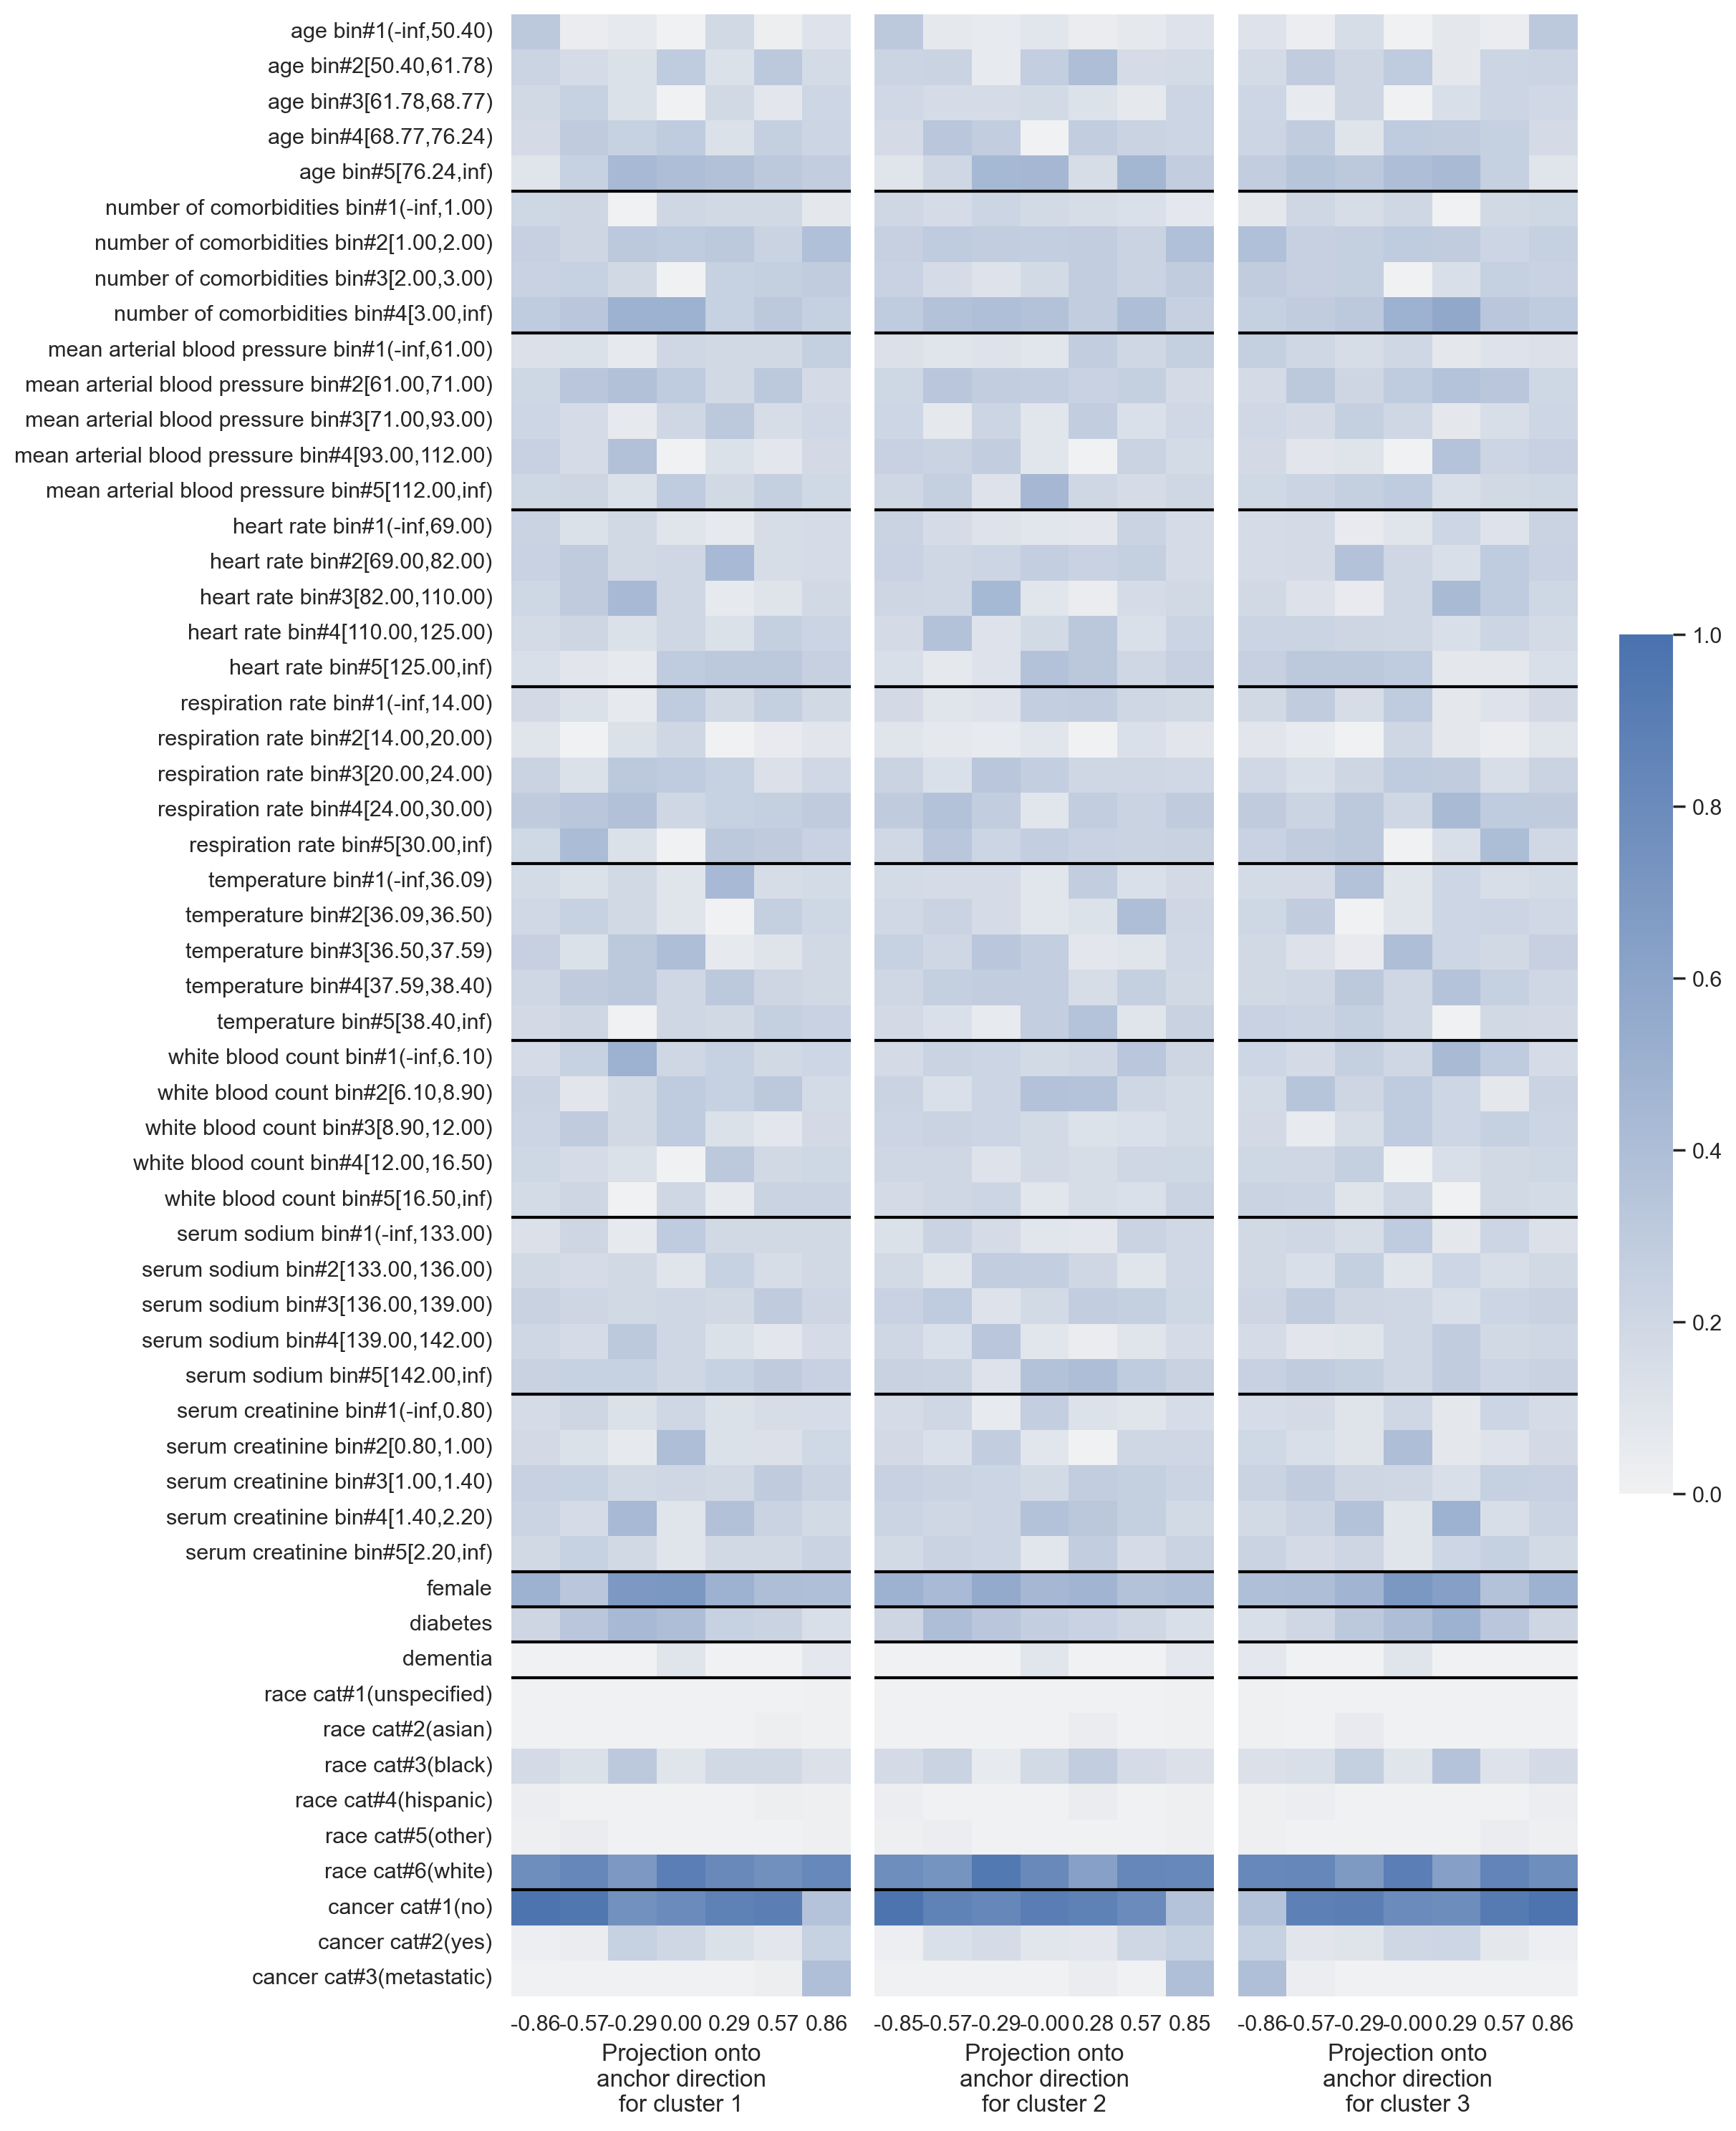

In [19]:
n_bins = 7
fig, axn = plt.subplots(1, final_n_clusters, sharex=False, sharey=True, figsize=(12.5, 15))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for cluster_idx in range(final_n_clusters):
    ax = axn.flat[cluster_idx]
    current_row = 0
    for idx, count in enumerate(all_n_bins_to_use[:-1]):
        current_row += count
        ax.plot([0, n_bins], [current_row, current_row], 'black')
    sns.heatmap(pd.DataFrame(all_raw_feature_probability_heatmaps[cluster_idx],
                             index=discretized_feature_names,
                             columns=['%.2f' % x for x in (all_bin_edges[cluster_idx][:-1]
                                                           + all_bin_edges[cluster_idx][1:])/2]),
                ax=ax,
                cmap=sns.light_palette("#4a72ae", reverse=False, as_cmap=True),
                vmin=0, vmax=1,
                cbar=(cluster_idx == 0),
                cbar_ax=None if (cluster_idx != 0) else cbar_ax)
    ax.set_xlabel('Projection onto\nanchor direction\nfor cluster %d' % (cluster_idx + 1))
fig.tight_layout(rect=[0, 0, .9, 1], pad=1.)
plt.savefig('support-raw-feature-prob-heatmaps-no-hypersphere.pdf', bbox_inches='tight')

Plot survival probability heatmaps (all in one big plot):

In [20]:
from scipy import interpolate

n_rows = 10
discrete_time_grid = np.linspace(unique_train_times.min(), unique_train_times.max(), n_rows)

all_survival_probability_heatmaps = []
for cluster_idx in range(final_n_clusters):
    projections = np.dot(emb_vis_normalized, anchor_directions_normalized[cluster_idx])

    bin_counts, bin_edges = np.histogram(projections, bins=n_bins)
    bin_edges_copy_with_inf_right_edge = bin_edges.copy()
    bin_edges_copy_with_inf_right_edge[-1] = np.inf

    bin_assignments = np.digitize(projections, bin_edges_copy_with_inf_right_edge) - 1

    heatmap = np.zeros((n_rows, n_bins))
    for projection_bin_idx in range(n_bins):
        projection_bin_surv = interpolate.interp1d(
            unique_train_times,
            predicted_surv_vis[bin_assignments == projection_bin_idx].mean(axis=0))
        heatmap[:, projection_bin_idx] = projection_bin_surv(discrete_time_grid)[::-1]

    all_survival_probability_heatmaps.append(heatmap)

/tmp/ipykernel_4002473/2388548300.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


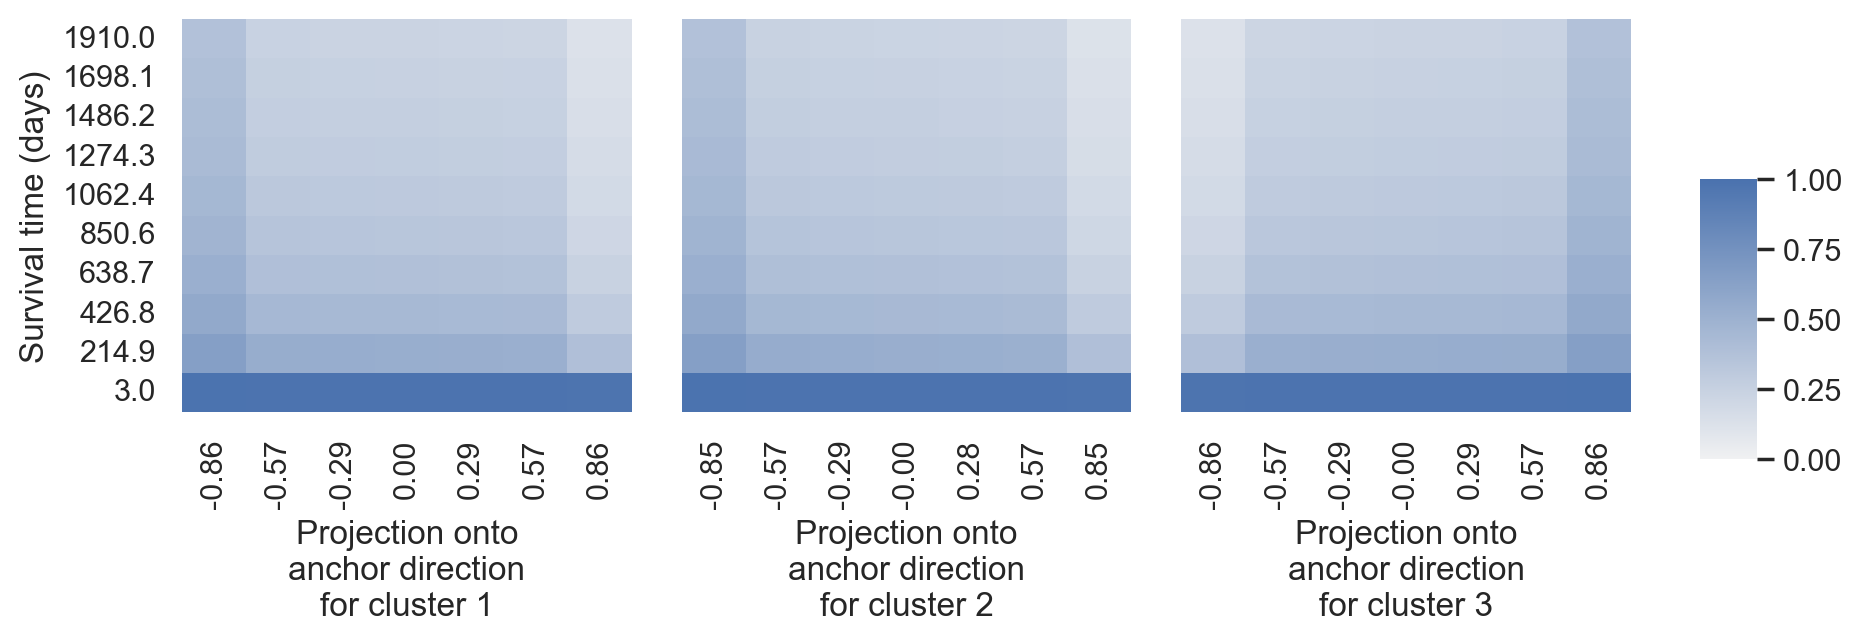

In [21]:
fig, axn = plt.subplots(1, final_n_clusters, sharex=False, sharey=True, figsize=(9.5, 3.5))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for cluster_idx in range(final_n_clusters):
    ax = axn.flat[cluster_idx]
    sns.heatmap(
        pd.DataFrame(all_survival_probability_heatmaps[cluster_idx],
                     index=['%.1f' % x for x in discrete_time_grid[::-1]],
                     columns=['%.2f' % x for x in (all_bin_edges[cluster_idx][:-1]
                                                   + all_bin_edges[cluster_idx][1:])/2]),
        cmap=sns.light_palette("#4a72ae", reverse=False, as_cmap=True),
        vmin=0, vmax=1, ax=ax,
        cbar=(cluster_idx == 0),
        cbar_ax=None if (cluster_idx != 0) else cbar_ax)
    ax.set_xlabel('Projection onto\nanchor direction\nfor cluster %d' % (cluster_idx + 1))
    if cluster_idx == 0:
        ax.set_ylabel('Survival time (days)')
fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)
plt.savefig('support-surv-prob-heatmaps-no-hypersphere.pdf', bbox_inches='tight')

For each cluster, plot a scatter plot of age vs projection value along the cluster's anchor direction:

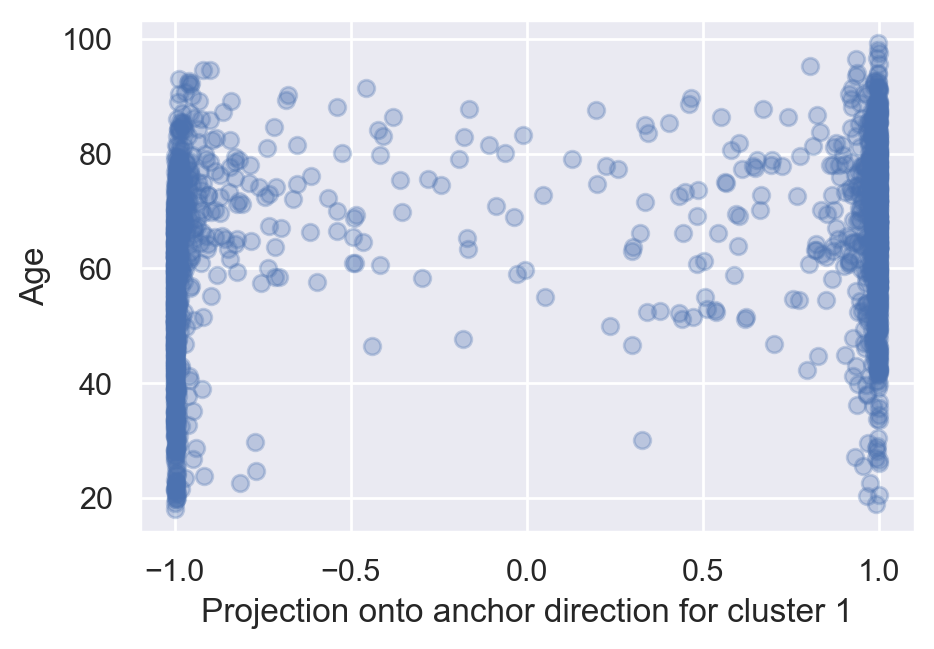

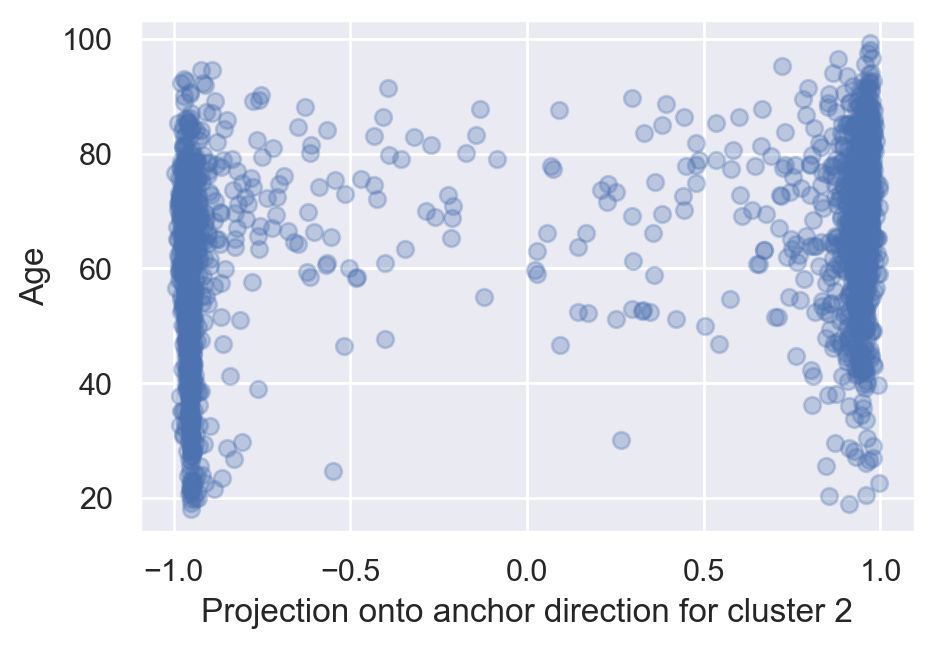

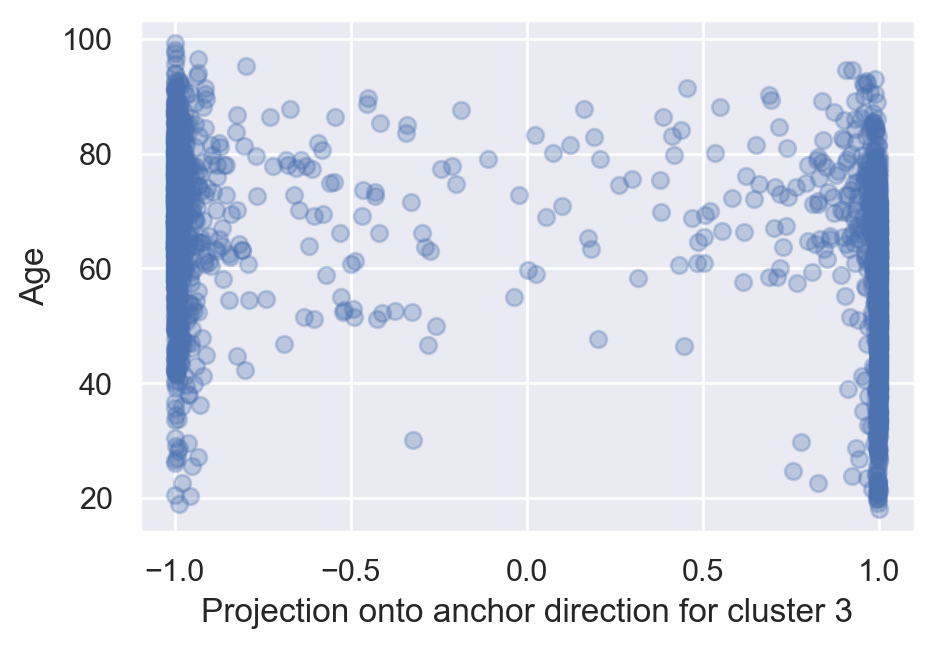

In [22]:
for cluster_idx in range(final_n_clusters):
    plt.figure(figsize=(5, 3.33))
    projections = np.dot(emb_vis_normalized, anchor_directions_normalized[cluster_idx])
    plt.scatter(projections, raw_vis[:, 0], alpha=.3)
    # sns.jointplot(projections, raw_vis[:, 0], kind="hist")
    plt.ylabel('Age')
    plt.xlabel('Projection onto anchor direction for cluster %d' % (cluster_idx + 1))
    plt.savefig('support-anchor%d-age-vs-proj-no-hypersphere.pdf' % (cluster_idx + 1), bbox_inches='tight')

### Feature interaction example

Here's an illustration of how to figure out possible feature interactions for each cluster's anchor direction. The basic idea: we train an "easy-to-interpret" regression model that maps from raw inputs to projection values for the anchor direction and where prediction allows for interactions. Here, we train a so-called *optimal regression tree* from the company Interpretable AI (requires a license). This method basically yields a single sparse tree where each leaf is determined by at most a few features (which are features that could have some interesting interaction). As we stated in our paper, we caution that these interactions should be interpreted with care (changing the max depth of the tree and using different random splits of the data for training and validation could potentially yield different trees and thus the interactions that get surfaced might not always be exactly the same).

In [23]:
from interpretableai import iai

raw_vis_race_onehot = np.hstack([raw_vis[:, [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]],
                                 1*(raw_vis[:, 2] == 0).reshape(-1, 1),
                                 1*(raw_vis[:, 2] == 1).reshape(-1, 1),
                                 1*(raw_vis[:, 2] == 2).reshape(-1, 1),
                                 1*(raw_vis[:, 2] == 3).reshape(-1, 1),
                                 1*(raw_vis[:, 2] == 4).reshape(-1, 1),
                                 1*(raw_vis[:, 2] == 5).reshape(-1, 1)])
columns = ['age',
           'female',
           'number of comorbidities',
           'diabetes',
           'dementia',
           'cancer',
           'mean arterial blood pressure',
           'heart rate',
           'respiration rate',
           'temperature',
           'white blood count',
           'serum sodium',
           'serum creatinine',
           'race (blank)',
           'race (Asian)',
           'race (black)',
           'race (hispanic)',
           'race (other)',
           'race (white)',
           'projection value']

def get_decision_tree(cluster_idx):
    projections = np.dot(emb_vis_normalized, anchor_directions_normalized[cluster_idx])
    df = pd.DataFrame(np.hstack((raw_vis_race_onehot, projections.reshape(-1, 1))),
                      columns=columns)
    X = df.iloc[:, 0:-1]
    y = df.iloc[:, -1]
    grid = iai.GridSearch(
        iai.OptimalTreeRegressor(
            random_seed=3943514174,
        ),
        max_depth=range(1, 4),
    )
    grid.fit_cv(X, y)
    learner = grid.get_learner()
    print(grid.get_learner())
    return learner

In [24]:
get_decision_tree(0)

[ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.


Fitted OptimalTreeRegressor:
  1) Split: cancer < 0.5
    2) Split: heart rate < 104.5
      3) Split: dementia < 0.5
        4) Predict: -0.708, 671 points, error 0.4163
        5) Predict: 0.9867, 36 points, error 0.0001578
      6) Split: age < 68.53
        7) Predict: -0.5486, 399 points, error 0.6105
        8) Predict: 0.6135, 225 points, error 0.5024
    9) Predict: 0.9202, 666 points, error 0.1138


Fitted OptimalTreeRegressor:
  1) Split: cancer < 0.5
    2) Split: heart rate < 104.5
      3) Split: dementia < 0.5
        4) Predict: -0.708, 671 points, error 0.4163
        5) Predict: 0.9867, 36 points, error 0.0001578
      6) Split: age < 68.53
        7) Predict: -0.5486, 399 points, error 0.6105
        8) Predict: 0.6135, 225 points, error 0.5024
    9) Predict: 0.9202, 666 points, error 0.1138

In [25]:
get_decision_tree(1)

Fitted OptimalTreeRegressor:
  1) Split: cancer < 0.5
    2) Split: heart rate < 104.5
      3) Split: dementia < 0.5
        4) Predict: -0.6863, 671 points, error 0.3827
        5) Predict: 0.948, 36 points, error 0.0009872
      6) Split: age < 68.53
        7) Predict: -0.5295, 399 points, error 0.5627
        8) Predict: 0.5695, 225 points, error 0.4858
    9) Predict: 0.865, 666 points, error 0.1147


Fitted OptimalTreeRegressor:
  1) Split: cancer < 0.5
    2) Split: heart rate < 104.5
      3) Split: dementia < 0.5
        4) Predict: -0.6863, 671 points, error 0.3827
        5) Predict: 0.948, 36 points, error 0.0009872
      6) Split: age < 68.53
        7) Predict: -0.5295, 399 points, error 0.5627
        8) Predict: 0.5695, 225 points, error 0.4858
    9) Predict: 0.865, 666 points, error 0.1147

In [26]:
get_decision_tree(2)

Fitted OptimalTreeRegressor:
  1) Split: cancer < 0.5
    2) Split: heart rate < 104.5
      3) Split: dementia < 0.5
        4) Predict: 0.7087, 671 points, error 0.4164
        5) Predict: -0.9869, 36 points, error 0.0001887
      6) Split: age < 68.53
        7) Predict: 0.549, 399 points, error 0.6105
        8) Predict: -0.612, 225 points, error 0.5042
    9) Predict: -0.9189, 666 points, error 0.1146


Fitted OptimalTreeRegressor:
  1) Split: cancer < 0.5
    2) Split: heart rate < 104.5
      3) Split: dementia < 0.5
        4) Predict: 0.7087, 671 points, error 0.4164
        5) Predict: -0.9869, 36 points, error 0.0001887
      6) Split: age < 68.53
        7) Predict: 0.549, 399 points, error 0.6105
        8) Predict: -0.612, 225 points, error 0.5042
    9) Predict: -0.9189, 666 points, error 0.1146